In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import csv

# Data creation

In [22]:
time = ['PipelineInfo_IngestionTime']
attributes = [
    "EventInfo_SdkVersion",
    "DeviceInfo_NetworkType",
    "UserInfo_TimeZone"
]
metric = ['records_received_count']

In [32]:
full_data = pd.read_csv("/lfs/1/jding/datasets/aria.csv", usecols=attributes+time+metric)

In [33]:
full_data["10min"] = pd.to_datetime(full_data['PipelineInfo_IngestionTime']).dt.round("10min")

In [34]:
full_data_clean = full_data[np.isfinite(full_data['records_received_count'])]

In [38]:
full_data_clean = full_data_clean.dropna(subset=['UserInfo_TimeZone'])

In [35]:
# full_data_clean.to_csv("/lfs/1/jding/datasets/aria-filtered.csv", index=False)

In [49]:
# full_data_clean["records_received_count"].to_csv("/lfs/1/jding/datasets/aria-metric.csv", index=False, header=["records_received_count"])

In [44]:
full_groups = full_data_clean.groupby(attributes + ["10min"])['records_received_count'].apply(list).reset_index()

In [124]:
# full_groups["records_received_count"].to_csv("/lfs/1/jding/datasets/aria-grouped.csv", index=False, header=["records_received_count"])

# Merge plot

In [10]:
sketches = ["cmoments", "yahoo", "random", "gk_adaptive", "tdigest", "sampling", "approx_histogram", "histogram"]

In [11]:
colormap = {
    "cmoments": "C0",
    "tdigest": "C1",
    "yahoo": "C2",
    "gk_adaptive": "C3",
    "histogram": "C4",
    "sampling": "C5",
    "approx_histogram": "C6",
    "random": "C7",
}
markers = {
    "cmoments": "x",
    "tdigest": "^",
    "yahoo": "s",
    "gk_adaptive": "+",
    "histogram": "D",
    "sampling": "o",
    "approx_histogram": "<",
    "random": ">",
}
alg_display_name = {
    "cmoments": "M-Sketch",
    "tdigest": "T-Digest",
    "yahoo": "Merge12",
    "gk_adaptive": "GK",
    "histogram": "EW-Hist",
    "sampling": "Sampling",
    "approx_histogram": "S-Hist",
    "random": "RandomW",
}

In [12]:
def get_error(sorted_data, x, p, is_int=False):
    if is_int:
        x = round(x)
    n = len(sorted_data)
    li = np.searchsorted(sorted_data, x, side="left")
    ri = np.searchsorted(sorted_data, x, side="right")
    qi = int(p * n)
    if ri < qi:
        return (qi-ri)*1.0/n
    elif li > qi:
        return (li-qi)*1.0/n
    else:
        return 0.0

In [13]:
def gen_plots(df, sorted_data, name, is_int=True):
    dft = df
    dft["error"] = dft.apply(
        lambda r: get_error(
            sorted_data, r["quantile_estimate"], r["q"],
            is_int=is_int
        ),
        axis=1
    )
    dft["rerror"] = dft["error"] / np.minimum(dft["q"],(1-dft["q"]))
    dfg = dft[dft["trial"] > 0].groupby([
        "sketch", "size_param"
    ])[
        "train_time","merge_time", "query_time", 
        "space", "error", "rerror", "bound_size", "n"
      ].mean()
    dfs = dfg.reset_index().sort_values(["size_param"])
    
    f, axs = plt.subplots(1,2, figsize=(6, 2.3), sharey=False)
    
    ax = axs[0]
    for alg in sketches:
        c_df = dfs[dfs["sketch"] == alg]
        l, = ax.loglog(
            c_df["space"], 
            (c_df["merge_time"])*1e-6/c_df["n"],
            label=alg_display_name[alg],
            marker=markers[alg],
            color=colormap[alg],
            markersize=5,
            ls="dotted",
            lw=1,
        )
    ax.set_xlabel("Size (bytes)")
    ax.set_ylabel("Merge Time (ms)")
    ax.set_ylim(bottom=1e-5)
    ax.yaxis.grid(True)
    
    ax = axs[1]
    lines = []
    labels = []
    for alg in sketches:
        c_df = dfs[dfs["sketch"] == alg]
        l, = ax.loglog(
            c_df["space"],
            c_df["error"], 
            label=alg_display_name[alg],
            marker=markers[alg],
            color=colormap[alg],
            markersize=5,
            ls="dotted",
            lw=1,
        )
        lines.append(l)
        labels.append(alg_display_name[alg])
    ax.set_xlabel("Size (Bytes)")
    ax.set_ylabel("Mean Error $\epsilon_{avg}$")
    ax.yaxis.grid(True)
    lgd = f.legend(
        lines, labels,
        bbox_to_anchor=(0.05, 1.05, 1., .102), ncol=4, loc=2,
        frameon=False
    )
    f.tight_layout()
    f.savefig("{}.pdf".format(name), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    return dft

In [14]:
orig_df = pd.read_csv("/lfs/1/jding/datasets/aria-metric.csv")
orig_data = orig_df["records_received_count"]
sorted_data = np.sort(orig_data)

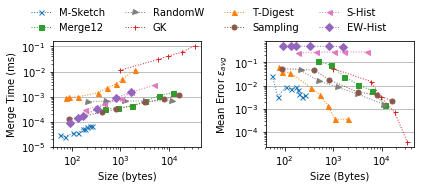

In [15]:
df = pd.read_csv("../javamsketch/results/merge_aria.csv")
dft = gen_plots(df, sorted_data, "aria_merge")

# CDF plot

In [2]:
metrics = pd.read_csv("/lfs/1/jding/datasets/aria-metric.csv")

In [3]:
groups = pd.read_csv("/lfs/1/jding/datasets/aria-grouped.csv")

In [4]:
sorted_metrics = metrics["records_received_count"].sort_values()

In [5]:
group_counts = groups["records_received_count"].apply(len)
sorted_group_counts = group_counts.sort_values()

In [6]:
sorted_metrics_sample = sorted_metrics.iloc[::100].append(pd.Series(sorted_metrics.iloc[-1]))

In [7]:
def gen_plot(sorted_metrics, sorted_group_counts, name):
    f, axs = plt.subplots(1,2, figsize=(6, 2.3), sharey=True)
    
    cdf_metrics = np.arange(len(sorted_metrics)) / float(len(sorted_metrics))
    cdf_groups = np.arange(len(sorted_group_counts)) / float(len(sorted_group_counts))
    
    ax = axs[0]
    ax.plot(sorted_metrics, cdf_metrics)
    ax.set_xscale('log')
    ax.set_title("Data Values")
    ax.set_ylabel("CDF")
    ax.set_xlabel("Value")
    ax.yaxis.grid(True)
    
    ax = axs[1]
    ax.plot(sorted_group_counts, cdf_groups)
    ax.set_xscale('log')
    ax.set_title("Cell Sizes")
    ax.set_xlabel("Cell Size")
    ax.yaxis.grid(True)
    
    f.tight_layout()
    f.savefig("{}.pdf".format(name))

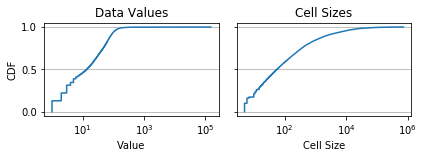

In [8]:
gen_plot(sorted_metrics_sample, sorted_group_counts, "aria_cdf")

# Combine results

In [9]:
df = pd.concat([
    pd.read_csv("../javamsketch/results/merge_aria_1527578344.csv"),
    pd.read_csv("../javamsketch/results/merge_aria_r_1527632457.csv"),
    pd.read_csv("../javamsketch/results/merge_aria_g_1527816607.csv")
])
df.to_csv("../javamsketch/results/merge_aria.csv")